In [41]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [ ]:
features = "mfcc_20_features_pitch"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

reader: 1069 | # samples 300
reader: 19 | # samples 300
reader: 201 | # samples 300
reader: 250 | # samples 300
reader: 254 | # samples 300
reader: 26 | # samples 300
reader: 27 | # samples 300
reader: 289 | # samples 300
reader: 298 | # samples 300
reader: 311 | # samples 300
reader: 32 | # samples 300
reader: 3240 | # samples 300
reader: 39 | # samples 300
reader: 40 | # samples 300
reader: 4297 | # samples 300
reader: 60 | # samples 300
reader: 78 | # samples 300
reader: 7800 | # samples 300
reader: 83 | # samples 300
reader: 87 | # samples 300


In [43]:
def partition_data(reader, max, split=.8):
    mfccs = [mfcc for mfcc in reader]
    mfccs = mfccs[0:max]

    mfccs_train = mfccs[0:round(len(mfccs)*split)]
    mfccs_test  = mfccs[round(len(mfccs)*split):len(mfccs)]

    return mfccs_train, mfccs_test

def partition_wrapper(data_dictionary, max):
    test_dict = {}
    train_dict = {}

    for key in data_dictionary.keys():
        train, test = partition_data(data_dictionary[key], max)
        train_dict[key] = train
        test_dict[key] = test

    return train_dict, test_dict 

In [40]:
def generate_random_indices(n, x, seed=42):
    if n > x + 1:
        raise ValueError("Cannot generate more unique numbers than the specified range.")
    
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(range(0, x), n)

def average_score(model,test_data):
    scores = []
    for data_point in test_data:
        scores.append(model.score(data_point.reshape(1,-1)))
    return scores, np.mean(scores)

def average_score_compare(model_dict, test_data_dict):
    for model_key in model_dict.keys():
        score_list = []
        for data_key in test_data_dict.keys():
            _, avg_score = average_score(model_dict[model_key], test_data_dict[data_key])
            avg_score = round(float(avg_score), 3)
            score_list.append((data_key, avg_score))
        print(f"model {model_key}: {score_list}")

def generate_binary_test_set(data_dict, key):
    if key not in data_dict:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    true_values = data_dict[key] # Get the list corresponding to the key

    num_other_classes = len(data_dict.keys()) - 1
    num_of_true_samples = len(true_values)

    samples_per_class = num_of_true_samples // num_other_classes
    # print(f"samples per class: {samples_per_class}")

    random_indices = generate_random_indices(samples_per_class, num_of_true_samples)

    test_set = true_values.copy()  # Start with the list for the specified key
    
    for k, v in data_dict.items():
        if k != key:  # Skip the list that corresponds to the key
            for i in random_indices:
                test_set.append(v[i])

    return test_set, num_of_true_samples

def generate_metrics(model_dict, data_dict, key):
   """
   Returns metrics for One-Class SVM using predict():
   - [TP, FP
      FN, TN].
   """
   
   model = model_dict[key]
   control_data = data_dict[key]

   # Concatenate data (assuming the data_dict is structured similarly to the original code)
   data, segments_length = generate_binary_test_set(data_dict, key)

   # Ground truth: first part is non-target (0), second part is target (1)
   ground_truth = [0] * segments_length + [1] * (len(data) - segments_length)
   
   # Get binary predictions (1 for inliers, -1 for outliers)
   predicted_labels = model.predict(data)

   # Convert predictions to binary labels: 1 for inliers, 0 for outliers
   predicted_labels = [1 if label == 1 else 0 for label in predicted_labels]

   # Generate confusion matrix and other metrics
   matrix = confusion_matrix(ground_truth, predicted_labels)
   accuracy = accuracy_score(ground_truth, predicted_labels)
   precision = precision_score(ground_truth, predicted_labels)
   recall = recall_score(ground_truth, predicted_labels)
   f1 = f1_score(ground_truth, predicted_labels)
   
   # For ROC AUC, we use the decision function to get the scores
   decision_scores = model.decision_function(data)
   roc_auc = roc_auc_score(ground_truth, decision_scores)
   fpr, tpr, _ = roc_curve(ground_truth, decision_scores)
   
   return matrix, accuracy, precision, recall, f1, roc_auc, fpr, tpr

def save_metrics(model_dict, data_dict, output_file="./metrics.txt"):
    metric_dict = {}
    
    for key in model_dict.keys():
        # threshold, matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)
        matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)

        if isinstance(matrix, np.ndarray):
            matrix = matrix.tolist()

        metric_dict[key] = {
            'matrix': matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
        
    accuracies = [metrics['accuracy'] for metrics in metric_dict.values()]
    precisions = [metrics['precision'] for metrics in metric_dict.values()]
    recalls = [metrics['recall'] for metrics in metric_dict.values()]
    f1_scores = [metrics['f1'] for metrics in metric_dict.values()]
    roc_aucs = [metrics['roc_auc'] for metrics in metric_dict.values()]

    def five_num_summary(values):
        return {
            'min': np.min(values),
            'q1': np.percentile(values, 25),
            'median': np.median(values),
            'q3': np.percentile(values, 75),
            'max': np.max(values),
            'mean': np.mean(values)
        }
    
    accuracy_summary = five_num_summary(accuracies)
    precision_summary = five_num_summary(precisions)
    recall_summary = five_num_summary(recalls)
    f1_summary = five_num_summary(f1_scores)
    roc_auc_summary = five_num_summary(roc_aucs)

    with open(output_file, 'w') as f:
        f.write(f"summary: \n")
        f.write(f"    five num sum accuracy : {accuracy_summary['min']:.4f} | {accuracy_summary['q1']:.4f} | {accuracy_summary['median']:.4f} | {accuracy_summary['q3']:.4f} | {accuracy_summary['max']:.4f} | mean: {accuracy_summary['mean']:.4f}\n")
        f.write(f"    five num sum precision: {precision_summary['min']:.4f} | {precision_summary['q1']:.4f} | {precision_summary['median']:.4f} | {precision_summary['q3']:.4f} | {precision_summary['max']:.4f} | mean: {precision_summary['mean']:.4f}\n")
        f.write(f"    five num sum recall   : {recall_summary['min']:.4f} | {recall_summary['q1']:.4f} | {recall_summary['median']:.4f} | {recall_summary['q3']:.4f} | {recall_summary['max']:.4f} | mean: {recall_summary['mean']:.4f}\n")
        f.write(f"    five num sum F1-score : {f1_summary['min']:.4f} | {f1_summary['q1']:.4f} | {f1_summary['median']:.4f} | {f1_summary['q3']:.4f} | {f1_summary['max']:.4f} | mean: {f1_summary['mean']:.4f}\n")
        f.write(f"    five num sum ROC AUC  : {roc_auc_summary['min']:.4f} | {roc_auc_summary['q1']:.4f} | {roc_auc_summary['median']:.4f} | {roc_auc_summary['q3']:.4f} | {roc_auc_summary['max']:.4f} | mean: {roc_auc_summary['mean']:.4f}\n")
        f.write("\n")

        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    accuracy: {metrics['accuracy']:.4f}\n")
            f.write(f"    precision: {metrics['precision']:.4f}\n")
            f.write(f"    recall: {metrics['recall']:.4f}\n")
            f.write(f"    F1-score: {metrics['f1']:.4f}\n")
            f.write(f"    ROC AUC: {metrics['roc_auc']:.4f}\n")
            
            # Formatting the matrix
            f.write(f"    matrix:\n")
            for row in metrics['matrix']:
                f.write(f"        {row}\n")
        f.write("\n")

    return metric_dict

def plot_roc_all(model_dict, data_dict, features_used="", save_dir=None):
    plt.figure(figsize=(13, 11))

    for key in model_dict.keys():
        _, _, _, _, _, roc_auc, fpr, tpr, = generate_metrics(model_dict, data_dict, key)
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models {features_used}')
    plt.legend(loc="lower right")

    if save_dir:    
        plt.savefig(os.path.join(save_dir, f"{features_used}.png"))
    plt.show()
    plt.close()  # Close plot to prevent overlap in successive calls

In [89]:
def train_svm(train_dict, key):
    training_data, segments_length = generate_binary_test_set(train_dict, key)
    training_data = np.vstack(training_data)
    ground_truth = [0] * segments_length + [1] * (len(training_data) - segments_length)
    
    model = SVC(kernel='linear', C=1.0, gamma='scale')
    return(model.fit(training_data, ground_truth))

def train_wrapper(train_dict):
    model_dict = {}

    for key in train_dict.keys():
        model_dict[key] = train_svm(train_dict, key)
    
    return(model_dict)

def train_one_class_svm(train_data):
    model = OneClassSVM(kernel="linear", nu=0.1, gamma="auto")
    return model.fit(train_data)

def train_one_class_svm_wrapper(train_dict):
    model_dict = {}

    for key in train_dict.keys():
        model_dict[key] = train_svm(train_dict, key)
    
    return(model_dict)

In [87]:
train_data, test_data = partition_wrapper(mfcc_stats_dict, 300)
speaker_models = train_wrapper(train_data)
speaker_models_one_class = train_one_class_svm_wrapper(train_data)

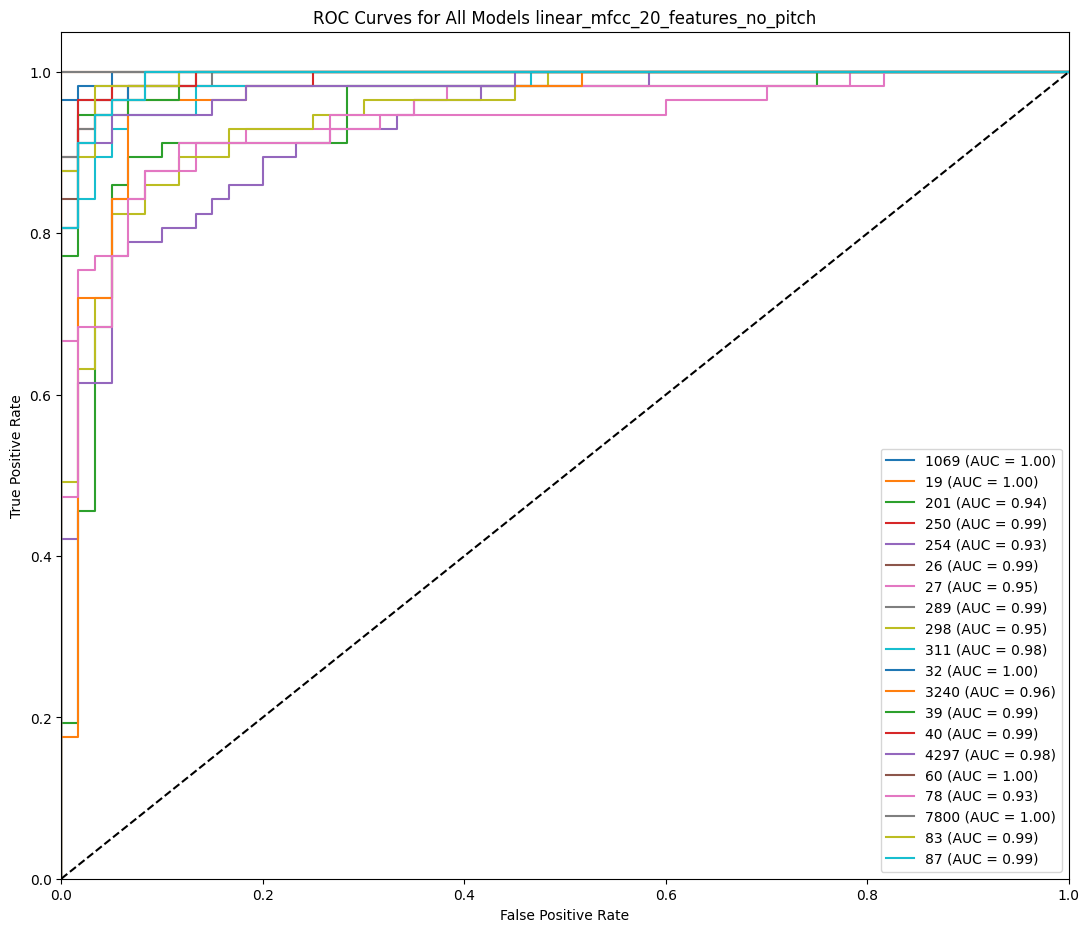

In [88]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/SVM/linear_{features}.txt")
plot_roc_all(speaker_models, test_data, features_used=f"linear_{features}", save_dir="./metrics/SVM/plots")

In [90]:
save_metrics(speaker_models_one_class, test_data, output_file=f"./metrics/SVM/{features}_oneclass.txt")

{'1069': {'matrix': [[59, 1], [2, 55]],
  'accuracy': 0.9743589743589743,
  'precision': np.float64(0.9821428571428571),
  'recall': np.float64(0.9649122807017544),
  'f1': np.float64(0.9734513274336283),
  'roc_auc': np.float64(0.9961988304093566)},
 '19': {'matrix': [[60, 0], [1, 56]],
  'accuracy': 0.9914529914529915,
  'precision': np.float64(1.0),
  'recall': np.float64(0.9824561403508771),
  'f1': np.float64(0.9911504424778761),
  'roc_auc': np.float64(1.0)},
 '201': {'matrix': [[56, 4], [6, 51]],
  'accuracy': 0.9145299145299145,
  'precision': np.float64(0.9272727272727272),
  'recall': np.float64(0.8947368421052632),
  'f1': np.float64(0.9107142857142857),
  'roc_auc': np.float64(0.9421052631578947)},
 '250': {'matrix': [[56, 4], [2, 55]],
  'accuracy': 0.9487179487179487,
  'precision': np.float64(0.9322033898305084),
  'recall': np.float64(0.9649122807017544),
  'f1': np.float64(0.9482758620689655),
  'roc_auc': np.float64(0.9926900584795322)},
 '254': {'matrix': [[28, 32], 